In [1]:
from pathlib import Path
import numpy as np
import shutil
import matplotlib.pyplot as plt

import post_pdf.posterior_pdf as pdf
import post_pdf.para_est_utils as utils

Import Neural Network model

In [2]:
curdir = Path().absolute()
result_reg_path = Path('example_NNmodel/')
reg1_path = result_reg_path/Path('y1/example_d171nm_8_param_y1_trained_model.h5')
reg2_path = result_reg_path/Path('y2/example_d171nm_8_param_y2_trained_model.h5')
scaler_path = result_reg_path/Path('example_d171nm_8_paramscaler.joblib')
train_path = result_reg_path/Path('example_d171nm_8_param_train_test.h5')
# define the start index of parameter which needs to be converted to logarithmic scale
ln_idx=3

c:\Users\e.kim\AppData\Local\miniconda3\envs\myGPU\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0, 0.5, 'current density (A/m²)')

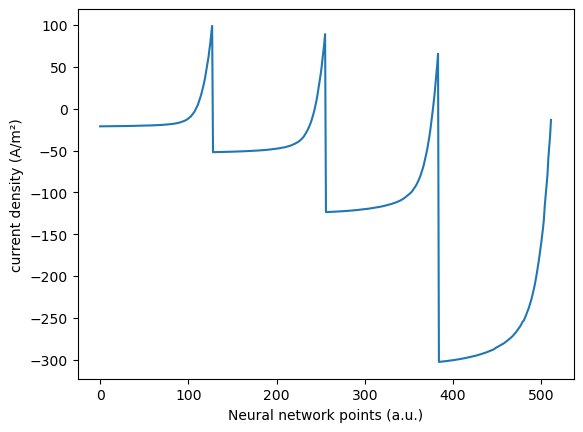

In [3]:
# define pdf class with NN model
post = pdf.posterior_pdf(reg1_path,reg2_path,scaler_path,train_path,ln_idx)

# attach sim_data or exp_data which is to be analyzed
True_paramsList = np.array([0.15,0.3,1.3,0.9,5e-6,5e-6,3e22,5e-18])
var_param = ["phibf", "phibb", "eg_abs1","suns", "mue_abs1", "muh_abs1", "dosdb_abs1", "kr_abs1"]
post.attach_simdata('NN', True_paramsList, var_param)

# define experimental uncertainty
phis = np.array([6,16,37,91])
std_phi=0.07
std_vol=1e-5
post.calc_sigma_exp(phis,std_phi,std_vol)

plt.plot(post.y_exp)
plt.xlabel("Neural network points (a.u.)")
plt.ylabel("current density (A/m²)")

Make result folder

In [4]:
mainfolder = result_reg_path/('testonSimu')
utils.make_folder(mainfolder)

the folder already exists!


Run genetic algorithm (CMA-ES) and approximate marginal likelihood by Monte Carlo integration


As shown in JV figure above, four JV curves are generated in this NN model.  
By using boolean variable ```obs_mask```, we can control which JV curve(s) to input in Bayesian inference runs.

In [5]:
obs_mask = [True, True, True, True]
num_obs = np.count_nonzero(obs_mask)

subfolder = mainfolder / (f'JV{num_obs}')
utils.make_folder(subfolder)
        
par_mat_ga, log_LH_ga = post.run_cmaes(obs_mask, num_run=2, shifterror=False, verbose=True)

# threshold_arr = [2,3,10]
# seq_num_std = 1e+4
# mc_inte_result = post.calc_mc_inte(par_mat_ga,log_LH_ga,calc_type='margLH',threshold_array=threshold_arr,seq_num_std=seq_num_std,num_run=10)

# # plot the result
# subsubfolder = subfolder / ('margLH')
# utils.make_folder(subsubfolder)

# filename = subsubfolder/('margLH_by_vol.pdf')
# utils.plot_mc_result(mc_inte_result,plot_figure=True,save_figure=False,figsize=[5,12],filename=filename)
# # save the result
# filename = subsubfolder/('marg_LH_vol.csv')
# utils.save_mc_result(mc_inte_result, x_type='vol',filename=filename)

the folder already exists!
cmaes calculation took --- 25.462291479110718 seconds ---
Best point at [[  0.32111099   0.2375849    1.3          0.90679541 -10.96308743
  -10.96308743  52.404655   -41.44653062]] with score [0.52575555]
cmaes calculation took --- 38.534656286239624 seconds ---
Best point at [[  0.15000012   0.30000002   1.3          0.89999998 -12.20607243
  -12.20607243  51.75548446 -39.83709446]] with score [1.5258104e-05]
Starting log likelihood calculation


In [ ]:
seq_num_array = [100,1000,10000,30000]
percentile_LLH = 3
mc_inte_result = post.calc_mc_inte(par_mat_ga,log_LH_ga,calc_type='margLH',seq_num_array=seq_num_array,threshold=percentile_LLH,num_run=5)
utils.plot_mc_result(mc_inte_result,save_figure=False,figsize=[5,12])
# save the result
utils.save_mc_result(mc_inte_result, x_type='seq_num')

After checking the result of integral, one can optionally decide which value to take. ```self.margLH=val```

### Visualize conditional posterior distribution function at $\theta_{\text{bestfit}}$

The conditional posterior distribution function is defined as following, when $\theta_{\text{bestfit}} = \left( \theta_{\text{bestfit, 1}}, \dots, \theta_{\text{bestfit, n}} \right)$:

$$
P\left( \theta_1, \theta_{\text{bestfit, 2}}, \dots, \theta_{\text{bestfit, n}} \mid J_{\text{obs}} \right) \quad \text{, where} \quad \theta_1 \in \left\{ \theta_1^{(i)} \right\}_{i=1}^m \\
$$
$\left\{ \theta_1^{(i)} \right\}_{i=1}^m$ is the equally-spaced grid points over the range of the interest.


the folder already exists!


c:\Users\e.kim\sciebo - Kim, Eunchi (e.kim@fz-juelich.de)@fz-juelich.sciebo.de\EunchiPBox\Project_JV_paraEstimation\NNmodel\113nm_device\post_pdf\posterior_pdf.py:605: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


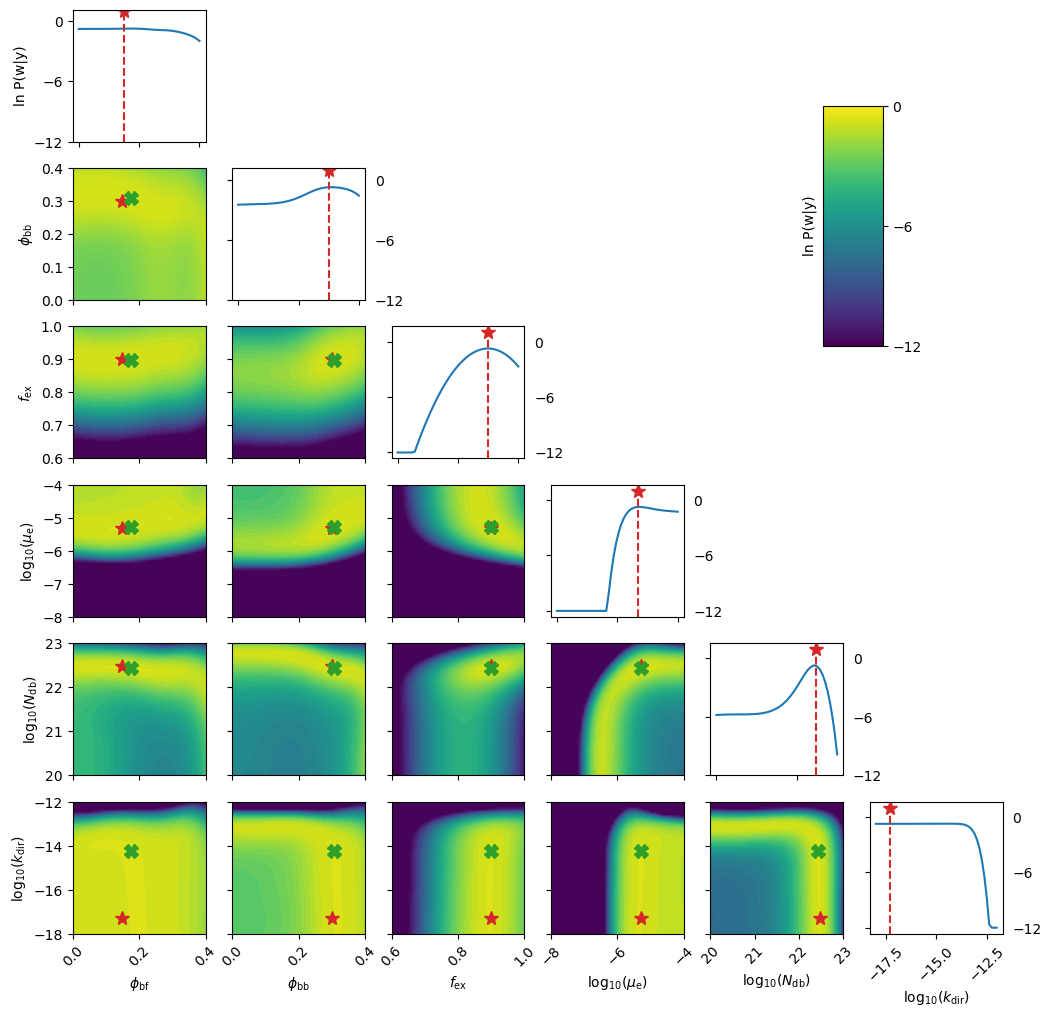

In [7]:
label = [r"$\phi_\mathrm{bf}$", r"$\phi_\mathrm{bb}$", r"$f_\mathrm{ex}$", r"log$_{10}(\mu_\mathrm{e})$",
         r"log$_{10}(N_\mathrm{db})$", r"log$_{10}(k_\mathrm{dir})$"]
header_csv = np.array([["Injection barrier \i(\g(f))\-(bf)", "Injection barrier \i(\g(f))\-(bb)", "Mult \i(f)\-(ex)", 
             "Electron mobility \g(\i(m))\-(e)","Deep defect density \i(N)\-(dt)", "Direct recombination coefficient \i(k)\-(dir)"],
              ['eV', 'eV','', 'Vs/m\+(2)', 'm\+(-3)', 'm\+(3) s\+(-1)']])
subsubfolder = subfolder / ('condpdf')
utils.make_folder(subsubfolder)

csv_filename = subsubfolder/('pdf_bestfit.csv')
fig_filename = subsubfolder/('pdf_bestfit.pdf')
post.plot_conditionalpdf(label ,header_csv,vmin=-12,plot_figure=True,save_figure=True,fig_filename=fig_filename,save_csv=True,csv_filename=csv_filename)

## Compare the input JV curves with the JV with $\theta_{\mathrm{bestfit}}$
In the following part, it is possible to construct the simulated JV curves with the 

the folder already exists!


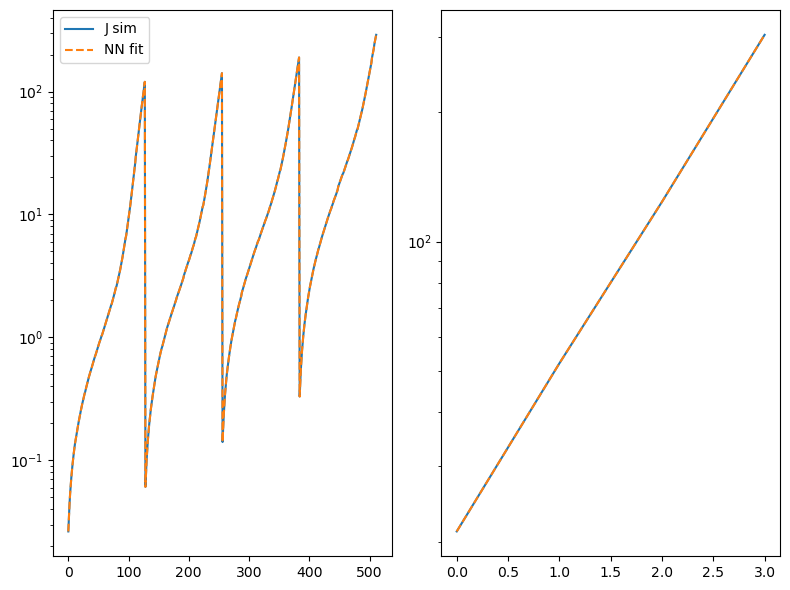

In [6]:
subsubfolder = subfolder / ('JVNN')
utils.make_folder(subsubfolder)

csv_filename = subsubfolder/('testonSimu.csv')
fig_filename = subsubfolder/('testonSimu')
post.checkNNfit(save_figure=True,save_csv=False,csv_filename=csv_filename,fig_filename=fig_filename)

## Calculation of Kullback-Leiber divergence (or relative entropy)
The Kullback-Leibler Divergence (KL Divergence) is a measure of the difference between two probability distributions. It is defined as:
$$D_{KL}(P || Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$$
where $P$ and $Q$ are two probability distributions, and $P(i)$ and $Q(i)$ are the probabilities of event $i$ under the distributions $P$ and $Q$, respectively.[1]

In the context of Bayesian inference, the KL Divergence is often used to measure the difference between the posterior distribution of a model and the prior distribution.  
Given a model with parameters $\theta$ and a prior distribution $p(\theta)$, the posterior distribution $p(\theta | D)$ is obtained by updating the prior distribution with the observed data $D$. The KL Divergence between the prior and posterior distributions is defined as:

$$D_{KL}(p(\theta | D) || p(\theta)) = \int p(\theta | D) \log \frac{p(\theta | D)}{p(\theta)} d\theta$$

This measures the difference between the prior distribution and the posterior distribution, which reflects the amount of information gained from the data.  
So, in the following part, we determine the KL divergence compared to the very first prior distribution (continuous uniform distribution) with the help of Monte Carlo integration.

[1] S. Kullback, R. A. Leibler, *The Annals of Mathematical Statistics* **1951**, *22*, 79.  
[2] K. Chaloner, I. Verdinelli, *Statistical Science 1995*, **10**, *273*.  
[3] S. Oladyshkin, W. Nowak, *Entropy* **2019**, 21.

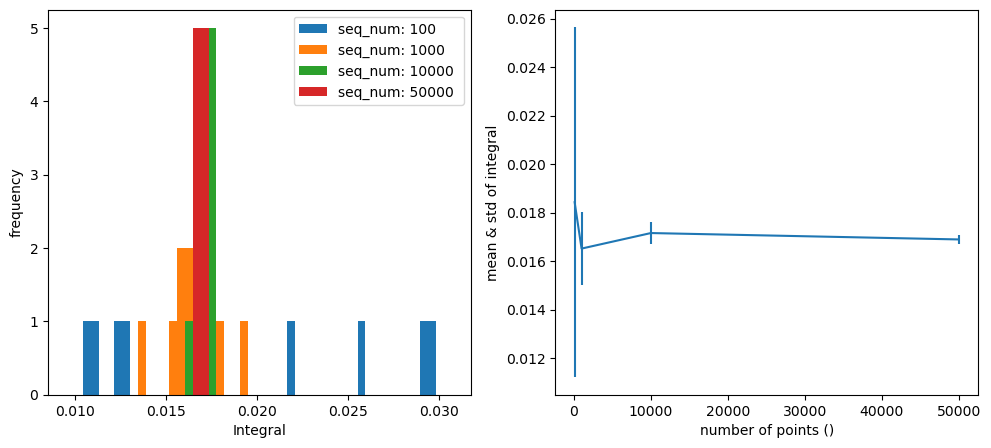

In [10]:
seq_num_array = [100,1000,10000,50000]
percentile_LLH = 0
mc_inte_result = post.calc_mc_inte(par_mat_ga,log_LH_ga,calc_type='entropy',seq_num_array=seq_num_array,threshold=percentile_LLH,num_run=10)

subsubfolder = subfolder / ('entropy')
utils.make_folder(subsubfolder)

filename = subsubfolder / 'entropy_mc_vol.pdf'
utils.plot_mc_result(mc_inte_result,save_figure=True,figsize=[5,12],filename=filename)
# save the result
filename = subsubfolder/('entropy_mc_vol.csv')
utils.save_mc_result(mc_inte_result, x_type='vol',filename=filename)

## Save posteior_pdf object

In [ ]:
filename = subfolder/('post_pdf.pkl')
post.save_pdf(filename)

shutil.copy('pdf_analysis_example_code.ipynb',subfolder/('pdf_analysis.ipynb'))

WindowsPath('Results/20241205-093436_d113nm/testonSimu/JV0/pdf_analysis.ipynb')